## Binary Classification

In [45]:
import h5py
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
file_path = 'bird_spectrograms.hdf5'  
f = h5py.File(file_path, 'r')

print("Available keys (species):")
print(list(f.keys()))

Available keys (species):
['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']


In [3]:
for key in f.keys():
    print(f"{key}: shape = {f[key].shape}")

amecro: shape = (128, 517, 66)
amerob: shape = (128, 517, 172)
bewwre: shape = (128, 517, 144)
bkcchi: shape = (128, 517, 45)
daejun: shape = (128, 517, 125)
houfin: shape = (128, 517, 84)
houspa: shape = (128, 517, 630)
norfli: shape = (128, 517, 37)
rewbla: shape = (128, 517, 187)
sonspa: shape = (128, 517, 263)
spotow: shape = (128, 517, 137)
whcspa: shape = (128, 517, 91)


In [4]:
with h5py.File('bird_spectrograms.hdf5', 'r') as f:
    houspa = np.transpose(f['houspa'][:], (2, 0, 1))  
    sonspa = np.transpose(f['sonspa'][:], (2, 0, 1))  

# Creating X and y
X = np.concatenate([houspa, sonspa], axis=0)
y = np.array([0] * len(houspa) + [1] * len(sonspa))

# Normalize and add channel dimension
X = X / np.max(X)
X = np.expand_dims(X, axis=1)  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

#70% train, 15% val, 15% test
total = len(dataset)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [11]:
class BirdBinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 129, 64)
        self.fc2 = nn.Linear(64, 2)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))
        return self.fc2(x)                    


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BirdBinaryCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(50):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(correct / total)

    # Validation step
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss_hist.append(val_loss / len(val_loader))
    val_acc_hist.append(val_correct / val_total)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss_hist[-1]:.4f} | "
          f"Val Loss: {val_loss_hist[-1]:.4f} | Train Acc: {train_acc_hist[-1]:.4f} | "
          f"Val Acc: {val_acc_hist[-1]:.4f}")

Epoch 01 | Train Loss: 27842571.0266 | Val Loss: 566352.2875 | Train Acc: 0.5584 | Val Acc: 0.3534
Epoch 02 | Train Loss: 182451.1409 | Val Loss: 43188.7266 | Train Acc: 0.6384 | Val Acc: 0.5639
Epoch 03 | Train Loss: 29667.0131 | Val Loss: 17392.8373 | Train Acc: 0.6624 | Val Acc: 0.5789
Epoch 04 | Train Loss: 8097.0353 | Val Loss: 2527.4461 | Train Acc: 0.6992 | Val Acc: 0.7895
Epoch 05 | Train Loss: 1803.5315 | Val Loss: 2959.4952 | Train Acc: 0.8128 | Val Acc: 0.7820
Epoch 06 | Train Loss: 828.8546 | Val Loss: 2337.0572 | Train Acc: 0.8368 | Val Acc: 0.7970
Epoch 07 | Train Loss: 537.6307 | Val Loss: 3357.6805 | Train Acc: 0.8704 | Val Acc: 0.6767
Epoch 08 | Train Loss: 694.3803 | Val Loss: 2917.4079 | Train Acc: 0.8672 | Val Acc: 0.7519
Epoch 09 | Train Loss: 229.3317 | Val Loss: 2778.0102 | Train Acc: 0.8928 | Val Acc: 0.7669
Epoch 10 | Train Loss: 181.8833 | Val Loss: 3337.5982 | Train Acc: 0.9248 | Val Acc: 0.6842
Epoch 11 | Train Loss: 495.5140 | Val Loss: 2790.1844 | Train Ac

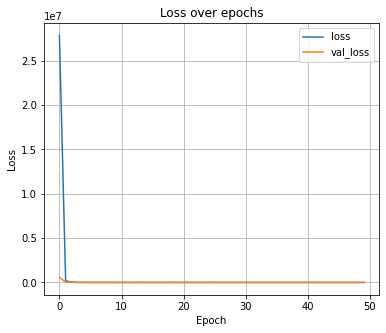

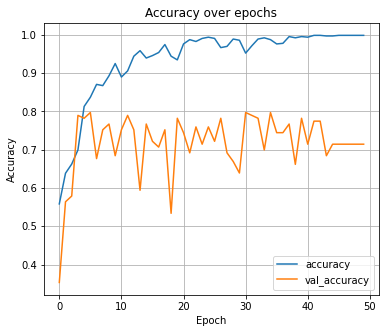

In [16]:
# Loss plot
plt.figure(figsize=(6, 5))
plt.plot(train_loss_hist, label='loss')
plt.plot(val_loss_hist, label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend(); plt.grid(True)
plt.show()

# Accuracy plot
plt.figure(figsize=(6, 5))
plt.plot(train_acc_hist, label='accuracy')
plt.plot(val_acc_hist, label='val_accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend(); plt.grid(True)
plt.show()

The above model seems to be overfitting

Epoch 01 | Train Loss: 4814029.9596 | Val Loss: 103.0182 | Train Acc: 0.4912 | Val Acc: 0.3609
Epoch 02 | Train Loss: 767.2579 | Val Loss: 0.6762 | Train Acc: 0.6640 | Val Acc: 0.6541
Epoch 03 | Train Loss: 1.6612 | Val Loss: 1.2905 | Train Acc: 0.6992 | Val Acc: 0.6466
→ No improvement. Early stopping trigger 1/5
Epoch 04 | Train Loss: 0.7625 | Val Loss: 0.6717 | Train Acc: 0.7024 | Val Acc: 0.6541
Epoch 05 | Train Loss: 0.6611 | Val Loss: 0.6695 | Train Acc: 0.6992 | Val Acc: 0.6541
Epoch 06 | Train Loss: 0.6534 | Val Loss: 0.6676 | Train Acc: 0.7040 | Val Acc: 0.6541
Epoch 07 | Train Loss: 6304.1504 | Val Loss: 0.6654 | Train Acc: 0.6800 | Val Acc: 0.6541
Epoch 08 | Train Loss: 0.6509 | Val Loss: 0.6632 | Train Acc: 0.6992 | Val Acc: 0.6541
Epoch 09 | Train Loss: 0.6475 | Val Loss: 0.6615 | Train Acc: 0.6992 | Val Acc: 0.6541
Epoch 10 | Train Loss: 0.6450 | Val Loss: 0.6600 | Train Acc: 0.6960 | Val Acc: 0.6541
Epoch 11 | Train Loss: 0.6434 | Val Loss: 0.6586 | Train Acc: 0.6992 | V

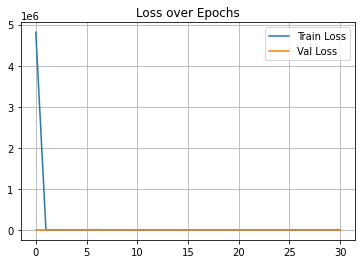

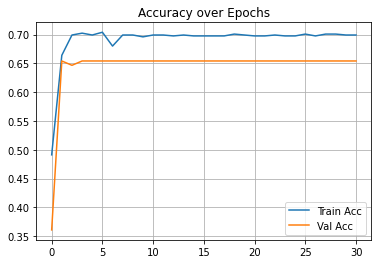

In [31]:
class BirdBinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 32 * 129, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BirdBinaryCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
patience = 5
trigger_times = 0
best_model_state = None

for epoch in range(50):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(correct / total)

    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            val_correct += (preds.argmax(dim=1) == yb).sum().item()
            val_total += yb.size(0)

    val_loss_hist.append(val_loss / len(val_loader))
    val_acc_hist.append(val_correct / val_total)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss_hist[-1]:.4f} | Val Loss: {val_loss_hist[-1]:.4f} | "
          f"Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_hist[-1]:.4f}")

    if val_loss_hist[-1] < best_val_loss:
        best_val_loss = val_loss_hist[-1]
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"→ No improvement. Early stopping trigger {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("→ Early stopping!")
            break


if best_model_state is not None:
    model.load_state_dict(best_model_state)


plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.legend(); plt.grid(); plt.title("Loss over Epochs")
plt.show()

plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.legend(); plt.grid(); plt.title("Accuracy over Epochs")
plt.show()

In [32]:
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))


Label distribution: {0: 630, 1: 263}


As we can see there is class imbalance 
I will be using weighted loss to handle the above

Epoch 01 | Train Loss: 20068768.7625 | Val Loss: 166566.2328 | Train Acc: 0.4864 | Val Acc: 0.6316
Epoch 02 | Train Loss: 8475.8781 | Val Loss: 0.6797 | Train Acc: 0.6848 | Val Acc: 0.6692
Epoch 03 | Train Loss: 0.6876 | Val Loss: 66.8724 | Train Acc: 0.7040 | Val Acc: 0.6617
→ No improvement. Early stopping trigger 1/5
Epoch 04 | Train Loss: 0.6871 | Val Loss: 68.4543 | Train Acc: 0.7040 | Val Acc: 0.6617
→ No improvement. Early stopping trigger 2/5
Epoch 05 | Train Loss: 0.6866 | Val Loss: 69.8422 | Train Acc: 0.7040 | Val Acc: 0.6617
→ No improvement. Early stopping trigger 3/5
Epoch 06 | Train Loss: 140.1127 | Val Loss: 68.0175 | Train Acc: 0.6880 | Val Acc: 0.6617
→ No improvement. Early stopping trigger 4/5
Epoch 07 | Train Loss: 0.6853 | Val Loss: 65.3332 | Train Acc: 0.7056 | Val Acc: 0.6617
→ No improvement. Early stopping trigger 5/5
→ Early stopping!


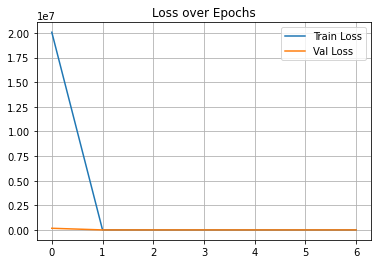

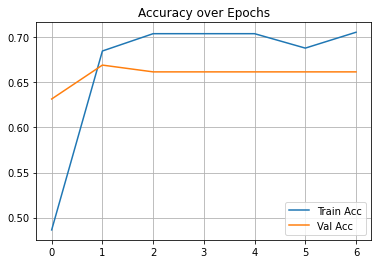

In [34]:
class BirdBinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 32 * 129, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BirdBinaryCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

class_counts = np.bincount(y)
weights = [sum(class_counts)/c for c in class_counts]
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
trigger_times = 0
best_model_state = None


train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
patience = 5
trigger_times = 0
best_model_state = None


for epoch in range(50):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(correct / total)

    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            val_correct += (preds.argmax(dim=1) == yb).sum().item()
            val_total += yb.size(0)

    val_loss_hist.append(val_loss / len(val_loader))
    val_acc_hist.append(val_correct / val_total)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss_hist[-1]:.4f} | Val Loss: {val_loss_hist[-1]:.4f} | "
          f"Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_hist[-1]:.4f}")

    if val_loss_hist[-1] < best_val_loss:
        best_val_loss = val_loss_hist[-1]
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"→ No improvement. Early stopping trigger {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("→ Early stopping!")
            break


if best_model_state is not None:
    model.load_state_dict(best_model_state)

plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.legend(); plt.grid(); plt.title("Loss over Epochs")
plt.show()

plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.legend(); plt.grid(); plt.title("Accuracy over Epochs")
plt.show()

Epoch 01 | Train Loss: 0.6964 | Val Loss: 0.6816 | Train Acc: 0.5600 | Val Acc: 0.6165
Epoch 02 | Train Loss: 0.6658 | Val Loss: 0.6536 | Train Acc: 0.5952 | Val Acc: 0.6090
Epoch 03 | Train Loss: 0.6367 | Val Loss: 0.7064 | Train Acc: 0.5904 | Val Acc: 0.7143
→ No improvement. Early stopping trigger 1/5
Epoch 04 | Train Loss: 0.6085 | Val Loss: 0.5987 | Train Acc: 0.6720 | Val Acc: 0.6842
Epoch 05 | Train Loss: 0.5635 | Val Loss: 0.5326 | Train Acc: 0.7264 | Val Acc: 0.6842
Epoch 06 | Train Loss: 0.5533 | Val Loss: 0.5304 | Train Acc: 0.7280 | Val Acc: 0.7970
Epoch 07 | Train Loss: 0.5197 | Val Loss: 0.4925 | Train Acc: 0.7424 | Val Acc: 0.8195
Epoch 08 | Train Loss: 0.5158 | Val Loss: 0.4802 | Train Acc: 0.7728 | Val Acc: 0.8195
Epoch 09 | Train Loss: 0.4739 | Val Loss: 0.4705 | Train Acc: 0.7632 | Val Acc: 0.8045
Epoch 10 | Train Loss: 0.4662 | Val Loss: 0.5026 | Train Acc: 0.7936 | Val Acc: 0.8045
→ No improvement. Early stopping trigger 1/5
Epoch 11 | Train Loss: 0.4801 | Val Loss

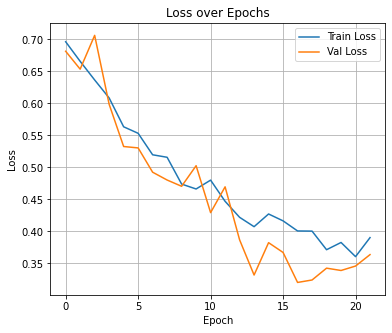

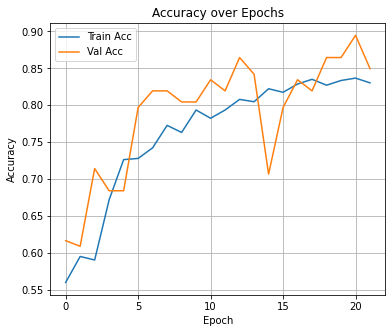

In [36]:
class BirdBinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x)  
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BirdBinaryCNN().to(device)
class_counts = np.bincount(y)
weights = [sum(class_counts) / c for c in class_counts]
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
patience, trigger_times = 5, 0
best_model_state = None

for epoch in range(50):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            val_correct += (preds.argmax(dim=1) == yb).sum().item()
            val_total += yb.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = val_correct / val_total
    val_loss_hist.append(val_loss_epoch)
    val_acc_hist.append(val_acc_epoch)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss_hist[-1]:.4f} | "
          f"Val Loss: {val_loss_epoch:.4f} | Train Acc: {train_acc_hist[-1]:.4f} | "
          f"Val Acc: {val_acc_epoch:.4f}")

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"→ No improvement. Early stopping trigger {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("→ Early stopping!")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

plt.figure(figsize=(6, 5))
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(); plt.grid(True)
plt.show()

In [38]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:  
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())


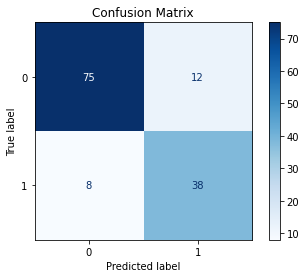

In [39]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [42]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_test_preds.extend(preds)
        all_test_labels.extend(yb.numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

Final Test Accuracy: 0.8074 (80.74%)



 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.83      0.87       107
     Class 1       0.53      0.71      0.61        28

    accuracy                           0.81       135
   macro avg       0.72      0.77      0.74       135
weighted avg       0.84      0.81      0.82       135



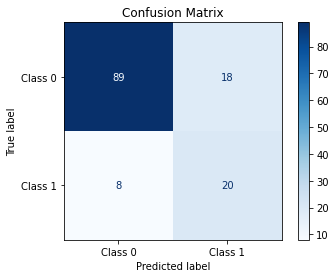

In [47]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_test_preds.extend(preds)
        all_test_labels.extend(yb.numpy())

print("\n Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=["Class 0", "Class 1"]))

cm = confusion_matrix(all_test_labels, all_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()